In [115]:
%load_ext pycodestyle_magic
%flake8_on
# la convention PEP8 est ainsi testée

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [583]:
# importer les packages
# common
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
# ml
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FactorAnalysis
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from kmodes.kmodes import KModes
# plot
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style('whitegrid')
%matplotlib inline

1: E999 SyntaxError: invalid syntax


In [117]:
# récupérer les données
data = pd.read_csv('Data/data.csv')

In [118]:
data.sample(5)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,N_RG_payment_total,N_RG_freight_percentage,N_RG_review_gap,N_RG_delivery_vs_estimated,N_RG_cust_sell_dist
29877,b282dff26b02dc8eb8715aa5996b13a0,b7afc661f446c22413d9f3e0c1b5aeed,2018-04-05 07:41:46,2018,4,5,3,7,Apr,Thu,...,0,0,0,1,0,0.193741,-0.968379,0.191052,-0.731217,-5.199338
49107,62c0ac109b07c5ee88e4af0defbcd93a,5184b8a8ed32a5a2fd1ec17cb443f3ef,2018-01-06 19:09:04,2018,1,6,5,19,Jan,Sat,...,0,0,0,0,0,1.248432,-1.552355,0.242903,-1.096804,0.256449
87140,817bf80f198fe79311b13572332cc969,a8af0900a6bccfc9b49d5747b4e0c094,2017-03-12 02:43:00,2017,3,12,6,2,Mar,Sun,...,0,0,0,1,0,0.648557,-1.358628,0.261573,-0.574460,-0.767598
59305,f1946ea4e7c8c7c67815ada3c62d1e17,43a60a424d49dc4f077f6a9cf69e3c82,2017-11-19 18:58:13,2017,11,19,6,18,Nov,Sun,...,1,0,0,0,0,-1.549177,1.428924,-0.242903,0.430727,0.736530
61592,c9b8db1f0bbeafcbea122f1fb447a1c3,41d681fd4ec9ef36e3429b2c19671000,2017-11-05 16:45:58,2017,11,5,6,16,Nov,Sun,...,0,0,0,1,0,-0.505135,-0.008048,-1.975216,0.255962,-0.513704


In [517]:
data_sample_10 = pd.DataFrame(data).sample(
    int(data.shape[0]/10),
    random_state=42)
data_sample_10.shape

(9036, 146)

In [519]:
data_sample_20 = pd.DataFrame(data).sample(
    int(data.shape[0]/5),
    random_state=42)
data_sample_20.shape

(18072, 146)

In [520]:
# rappel des features
# pour découper des jeux de données temporelles
temporal_cut_features = ['order_purchase_year', 'order_purchase_month']
# pour décrire les clusters (on retire les données produits)
for_lvl_features = ['payment_lvl',
                    'delivery_vs_estimated_lvl',
                    'freight_percentage_lvl',
                    'cust_sell_dist_lvl',
                    'review_gap_lvl']
# pour décrire les catégories de produit
cat_feat_product = data.columns[data.columns.str.contains(
    'rational_category_')].tolist()
# pour identifier les moments d'achat
cat_feat_order = data.columns[data.columns.str.contains(
    'purchase_time_zone_')].tolist()
# suite à la priorisation des features numériques
std_feature_selection = data.columns[data.columns.str.contains(
    'N_RG_')].tolist()

In [521]:
std_feature_selection

['N_RG_payment_total',
 'N_RG_freight_percentage',
 'N_RG_review_gap',
 'N_RG_delivery_vs_estimated',
 'N_RG_cust_sell_dist']

In [522]:
# projection des données sur les features
data_selection = data.filter(std_feature_selection)
data_selection.shape

(90360, 5)

In [523]:
data_selection.sample(3)

,N_RG_payment_total,N_RG_freight_percentage,N_RG_review_gap,N_RG_delivery_vs_estimated,N_RG_cust_sell_dist
84926,0.357086,0.241978,-1.679080,0.430727,1.811365
41151,0.068476,0.329897,-0.242903,0.255962,-0.486994
57771,-1.196672,1.022885,-0.889495,-0.430727,0.139710


In [525]:
# projection des données sur les features
data_sel_sample10 = data_sample_10.filter(std_feature_selection)
data_sel_sample20 = data_sample_20.filter(std_feature_selection)

# Clustering hierarchique

##  Distances : Euclidienne, Mahalabonis, CityBlock
Observations sur des échantillons de 10 et 20% des données.

In [51]:
cl_eucl_10 = linkage(data_sel_sample10, method='complete', metric='euclidean')

In [52]:
cl_eucl_20 = linkage(data_sel_sample20, method='complete', metric='euclidean')

In [53]:
cl_mahal_10 = linkage(data_sel_sample10, method='complete', metric='mahalanobis')

In [54]:
cl_mahal_20 = linkage(data_sel_sample20, method='complete', metric='mahalanobis')

In [55]:
cl_citybl_10 = linkage(data_sel_sample10, method='complete', metric='cityblock')

In [526]:
cl_citybl_20 = linkage(data_sel_sample20, method='complete', metric='cityblock')

In [527]:

def dendo(cl1, cl2, cl1_label, cl2_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 5])
    ax1.set_xlabel('Customers', fontsize=12)
    ax1.set_ylabel('Distance', fontsize=12)
    ax1.set_title('Dendrogram ' + cl1_label, fontsize=13)
    ax1.tick_params(axis='both', which='major', labelsize=13)
    dendrogram(cl1,
               leaf_rotation=90,
               leaf_font_size=12,
               truncate_mode='lastp',
               show_leaf_counts=True,
               ax=ax1,
               )
    ax2.set_xlabel('Clients', fontsize=12)
    ax2.set_ylabel('Distance', fontsize=12)
    ax2.set_title('Dendrogram ' + cl2_label, fontsize=13)
    ax2.tick_params(axis='both', which='major', labelsize=13)
    dendrogram(cl2,
               leaf_rotation=90,
               leaf_font_size=12,
               truncate_mode='lastp',
               show_leaf_counts=True,
               ax=ax2)
    plt.show()

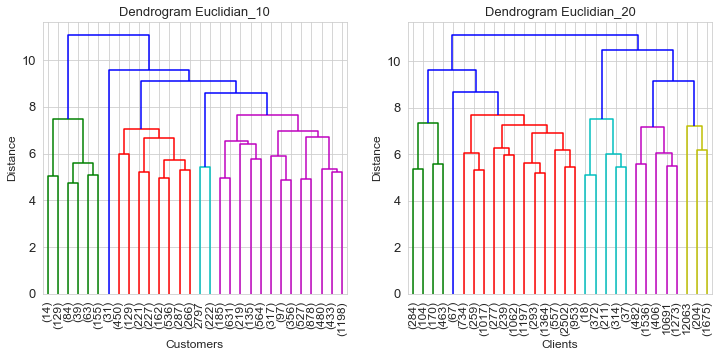

In [528]:
dendo(cl_eucl_10, cl_eucl_20, 'Euclidian_10', 'Euclidian_20')

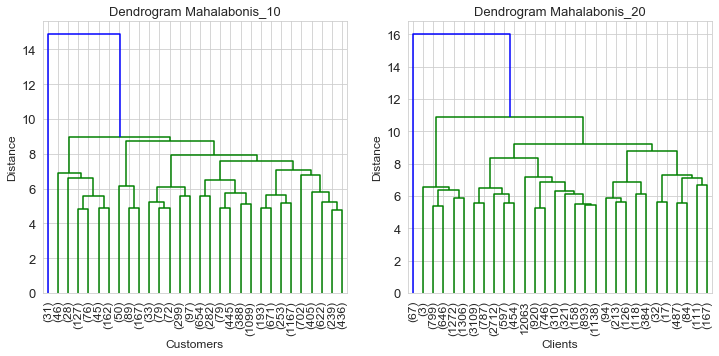

In [529]:
dendo(cl_mahal_10, cl_mahal_20, 'Mahalabonis_10', 'Mahalabonis_20')

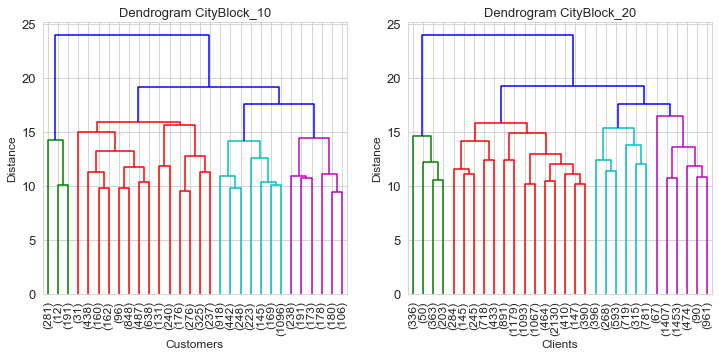

In [530]:
dendo(cl_citybl_10, cl_citybl_20, 'CityBlock_10', 'CityBlock_20')

- la claissification hiérachique la plus exploitable semble construire à partir de la distance euclidienne et s'améliore avec la taille de l'échantillon

In [531]:
HClustLabels = fcluster(cl_citybl_20, 4, criterion='maxclust')

In [532]:
HClust = data_sample_20.copy()

In [533]:
HClust['clusters'] = HClustLabels

In [534]:
HClust.sample(5)

,order_id,customer_id,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_dayofweek,order_purchase_hour,order_purchase_month_label,order_purchase_dayofweek_label,...,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,N_RG_payment_total,N_RG_freight_percentage,N_RG_review_gap,N_RG_delivery_vs_estimated,N_RG_cust_sell_dist,clusters
12796,246e2c3c7b7c4759966d8a76513b0ad8,1e1eeb9b7a16eb780c2728c498d5ea2b,2018-06-26 14:43:49,2018,6,26,1,14,Jun,Tue,...,0,0,0,0,-1.046231,1.681633,0.295415,1.690622,0.205128,2
37483,2062e2b2ccba806425dfce0142c62a84,a841867b4ef1d25a49431a4dbec2a77f,2018-02-28 20:05:19,2018,2,28,2,20,Feb,Wed,...,0,0,1,0,-0.736091,-0.117737,0.748811,-0.295415,-1.297857,2
53148,738a743a02fd55d22839341f0d696e4b,31bd04a70aa18c5d0a7c018476942bf7,2017-12-10 19:30:45,2017,12,10,6,19,Dec,Sun,...,0,0,1,0,-0.043819,-0.470855,-1.260726,-2.331506,-0.643262,4
39410,8b75cb6fd9531cacf7f2cb7dadf7467b,1a663679384785e911792fb4a86d61c4,2018-02-20 18:35:00,2018,2,20,1,18,Feb,Tue,...,1,0,0,0,0.496960,-0.869568,-0.242903,-0.050661,-0.500893,4
80287,dca240cc5f341c09ac34712505d7a4dd,fdb7e93904c944838363ba364d85a402,2017-05-31 20:59:25,2017,5,31,2,20,May,Wed,...,0,0,1,0,-1.666429,1.728951,0.928836,0.559592,0.048703,2


Text(0.5, 1.02, 'Cluster nb')

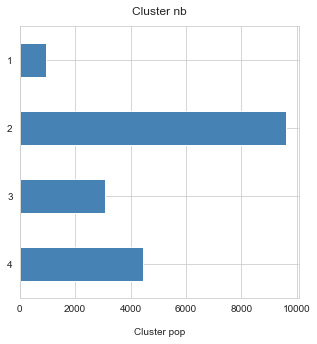

In [535]:
# observer la répartition des effectifs dans les clusters
HClust['clusters'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Cluster pop', labelpad=14)
plt.title('Cluster nb', y=1.02)

In [555]:
HClust1 = HClust[HClust['clusters'] == 1]
HClust1.name = 'cluster 1'
HClust2 = HClust[HClust['clusters'] == 2]
HClust2.name = 'cluster 2'
HClust3 = HClust[HClust['clusters'] == 3]
HClust3.name = 'cluster 3'
HClust4 = HClust[HClust['clusters'] == 4]
HClust4.name = 'cluster 4'

In [563]:

def SalesClust(data):
    SalesClust = data.groupby(
        'rational_category',
        as_index=False).agg({'payment_total': ['sum']})
    SalesClust.columns = ['rational_category',
                          'sales']
    SalesClust = SalesClust.sort_values(by=['sales'],
                                        ascending=False)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.barplot(y='rational_category',
                     x='sales',
                     color='Steelblue',
                     data=SalesClust[:5])
    ax.set(xlabel='Sales Revenue',
           ylabel='Products Categories',
           title='Top 5 Sales by Category : ' + str(data.name))

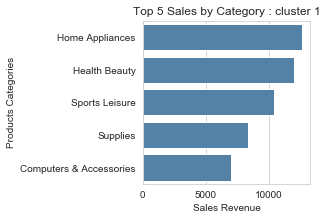

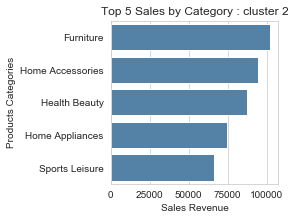

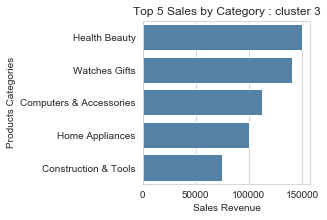

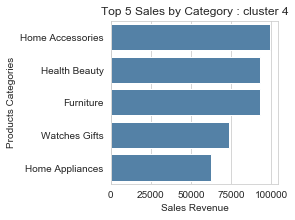

In [564]:
for i in [HClust1, HClust2, HClust3, HClust4]:
    SalesClust(i)

In [586]:
label_color_map = {1: 'r',
                   2: 'k',
                   3: 'b',
                   4: 'g'}

Text(0.5, 0, 'Rank-Gaussed Cust_Sell distance')

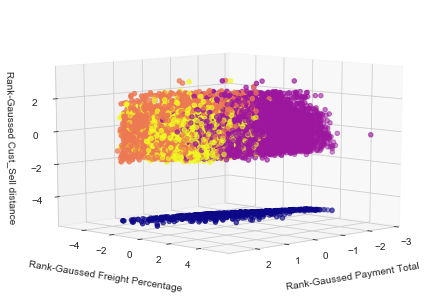

In [561]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(HClust['N_RG_payment_total'],
           HClust['N_RG_freight_percentage'],
           HClust['N_RG_cust_sell_dist'],
           cmap='plasma',
           c=HClust['clusters'])
ax.view_init(elev=10, azim=45)
ax.set_xlabel('Rank-Gaussed Payment Total', labelpad=15)
ax.set_ylabel('Rank-Gaussed Freight Percentage', labelpad=15)
ax.set_zlabel('Rank-Gaussed Cust_Sell distance')

Text(0.5, 0, 'Rank-Gaussed Delivery vs Estimated')

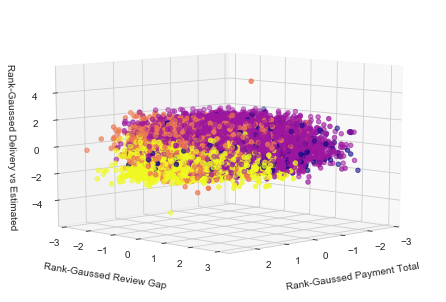

In [562]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(HClust['N_RG_payment_total'],
           HClust['N_RG_review_gap'],
           HClust['N_RG_delivery_vs_estimated'],
           cmap='plasma',
           c=HClust['clusters'])
ax.view_init(elev=10, azim=45)
ax.set_xlabel('Rank-Gaussed Payment Total', labelpad=15)
ax.set_ylabel('Rank-Gaussed Review Gap', labelpad=15)
ax.set_zlabel('Rank-Gaussed Delivery vs Estimated')

Text(0.5, 1.02, 'Purchase Time Zones')

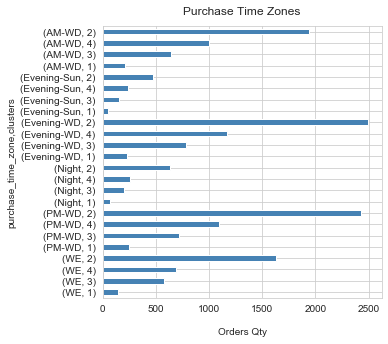

In [574]:
HClust.groupby('purchase_time_zone').clusters.value_counts().plot(
        kind='barh',
        color='steelblue',
        figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Purchase Time Zones', y=1.02)

- on conclue à une répartition homogène des achats par moment de la semaine

# PCA
On déroule une PCA en commençant par les features selectionnés

In [61]:
data_selection.sample(3)

,N_RG_payment_total,N_RG_freight_percentage,N_RG_review_gap,N_RG_delivery_vs_estimated,N_RG_cust_sell_dist
34876,-0.559602,2.112253,1.406866,-0.295415,1.599198
46121,-0.924188,0.796201,-0.242903,1.470545,0.895713
69579,-2.049594,0.773373,2.011555,-0.731217,-1.495474


In [62]:
# aperçu sur 2 dimensions
pca = PCA(n_components=2)
pca_n2 = pca.fit_transform(data_selection)
pca_df = pd.DataFrame(
    data=pca_n2, columns=['F1',
                          'F2'])

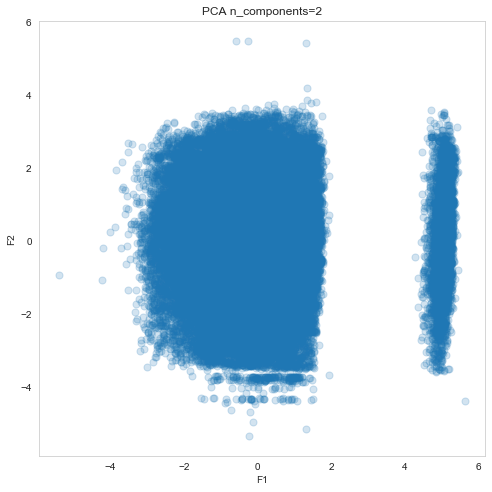

In [63]:
# afficher les données selon les 2 dimensions
fig = plt.figure(figsize=(5, 5))
ax.set_xlabel('F1', fontsize=10)
ax.set_ylabel('F2', fontsize=10)
ax.set_title('PCA n_components=2', fontsize=12)
ax.scatter(principalDf['F1'],
           principalDf['F2'], s=50, alpha=0.2)
ax.grid()

In [64]:
# variance
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.37011774 0.2794513 ]
0.6495690431658023


(-1.1, 1.1)

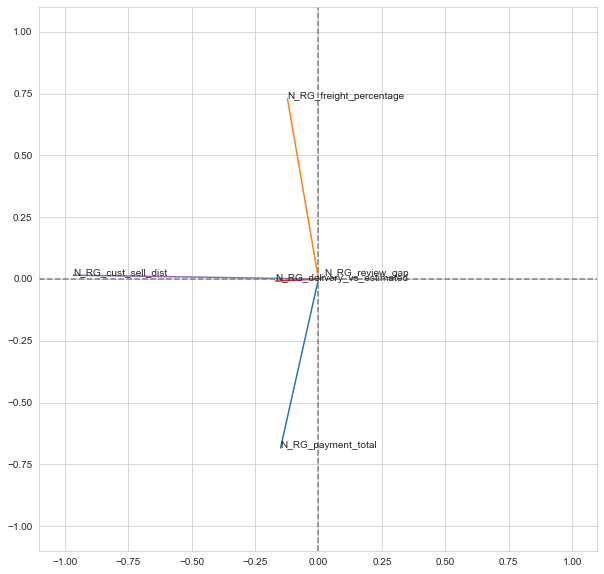

In [66]:
# contribution des variables aux 2 composantes
pcs = pca.components_

fig = plt.figure(figsize=(10, 10))
for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.plot([0, x], [0, y])
    plt.text(x, y, data_selection.columns[i])
plt.plot([-1.1, 1.1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1.1, 1.1], color='grey', ls='--')
plt.xlim([-1.1, 1.1])
plt.ylim([-1.1, 1.1])

In [67]:
# avec 3 composants
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data_selection)
principalDf = pd.DataFrame(
    data=principalComponents, columns=['F1',
                                       'F2',
                                       'F3'])

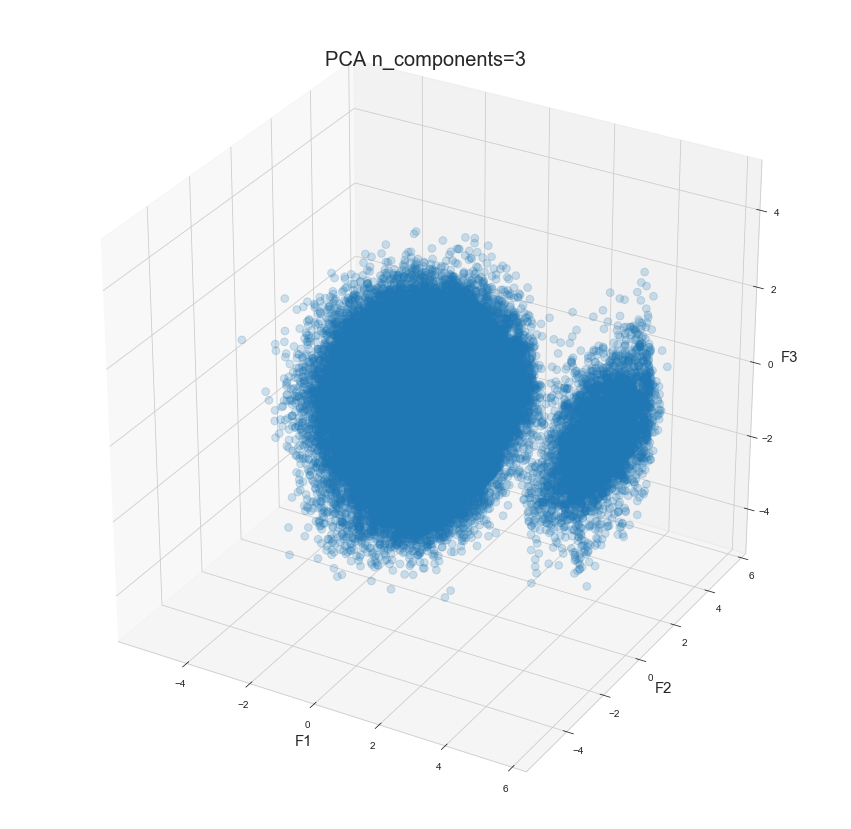

In [68]:
# afficher les données selon les 3 dimensions
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('F1', fontsize=15)
ax.set_ylabel('F2', fontsize=15)
ax.set_zlabel('F3', fontsize=15)
ax.set_title('PCA n_components=3', fontsize=20)

ax.scatter(principalDf['F1'],
           principalDf['F2'],
           principalDf['F3'],
           s=60,
           alpha=0.2)
ax.grid()

In [69]:
# variance
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.37011774 0.2794513  0.18138336]
0.8309524011458206


In [70]:
# nombre optimal de components
pca = PCA()
pca.fit(data_selection)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [71]:
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)


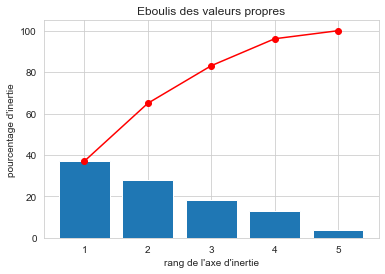

In [72]:
display_scree_plot(pca)

- nous avions fait un premier constat que le charm_price est en lui même un critère déterminant (seul catégoriel retenu)
- nous allons dérouler une PCA en ajoutant les purchase_timezone

In [76]:
# projection des données sur les features
data_wide_selection = data.filter(std_feature_selection + cat_feat_order)
data_wide_selection.shape

(90360, 11)

In [81]:
names = []
for i in range(1, 5):
    elt = 'F' + str(i)
    names.append(elt)

In [82]:
pca_optimal = PCA(n_components=4)
principalComponents_optimal = pca_optimal.fit_transform(data_selection)
data_optimal = pd.DataFrame(
    data=principalComponents_optimal, columns=names, index=data_selection.index)

In [83]:
data_optimal.head(5)

,F1,F2,F3,F4
0,0.892987,-0.598070,-0.001660,-1.031249
1,1.721864,1.464836,-0.760604,-0.423628
2,-0.075345,0.875573,0.622205,-0.654445
3,4.766141,-1.260071,-0.394819,0.227113
4,5.147649,-0.191992,-1.332077,0.920701


In [84]:
sum(pca_optimal.explained_variance_ratio_)

0.9611256838727906

# K - Means

on réalise un clustering k-means sur les données transformées / PCA

In [85]:
sse = {}
# silhouette = {}
dbs = {}
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(data_optimal)
    # silhouette[k] = metrics.silhouette_score(data_optimal,
    #                                         kmeans.labels_)
    sse[k] = kmeans.inertia_
    dbs[k] = metrics.davies_bouldin_score(
        data_optimal,
        kmeans.labels_)

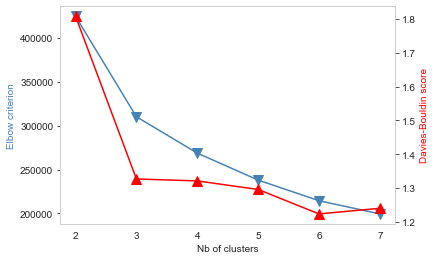

In [86]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)
ax1.plot(list(sse.keys()),
         list(sse.values()),
         'v-',
         markersize=10,
         color='steelblue')
ax2.plot(list(dbs.keys()),
         list(dbs.values()),
         '^-',
         markersize=10,
         color='red')
ax1.set_xlabel('Nb of clusters')
ax1.set_ylabel('Elbow criterion', color='steelblue')
ax2.set_ylabel('Davies-Bouldin score', color='red')
plt.show()

In [74]:
# plt.title('Silhouette Score')
# sns.pointplot(x=list(silhouette.keys()), y=list(silhouette.values()))

In [92]:
kmeans_optimal = KMeans(n_clusters=3, random_state=42)
kmeans_optimal.fit_predict(data_optimal)

array([0, 1, 1, ..., 0, 1, 1])

In [93]:
kmeans_optimal.inertia_

310119.506322904

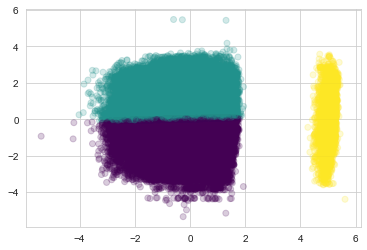

In [94]:
# afficher les données selon les 2 dimensions
plt.scatter(data_optimal['F1'], data_optimal['F2'], c=kmeans_optimal.labels_.astype(np.float), cmap='viridis', alpha=.2)

In [95]:
metrics.silhouette_score(data_optimal, kmeans_optimal.labels_)

0.23374728166611183

- K-means à partir de données sans PCA

In [99]:
sse = {}
# silhouette = {}
dbs = {}
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(data_selection)
    # silhouette[k] = metrics.silhouette_score(data_selection,
    #                                         kmeans.labels_)
    sse[k] = kmeans.inertia_
    dbs[k] = metrics.davies_bouldin_score(
        data_selection,
        kmeans.labels_)

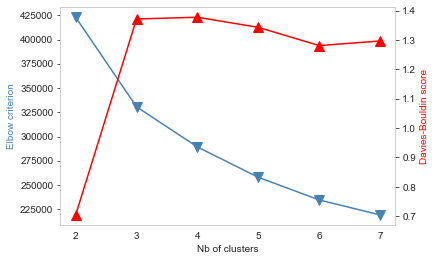

In [100]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)
ax1.plot(list(sse.keys()),
         list(sse.values()),
         'v-',
         markersize=10,
         color='steelblue')
ax2.plot(list(dbs.keys()),
         list(dbs.values()),
         '^-',
         markersize=10,
         color='red')
ax1.set_xlabel('Nb of clusters')
ax1.set_ylabel('Elbow criterion', color='steelblue')
ax2.set_ylabel('Davies-Bouldin score', color='red')
plt.show()

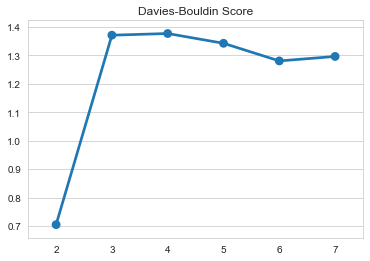

In [101]:
plt.title('Davies-Bouldin Score')
sns.pointplot(x=list(dbs.keys()), y=list(dbs.values()))

In [102]:
kmeans_optimal = KMeans(n_clusters=2, random_state=42)
kmeans_optimal.fit_predict(data_selection)

array([0, 0, 0, ..., 0, 0, 0])

In [103]:
kmeans_optimal.inertia_

423005.451066482

In [104]:
data_selection

,N_RG_payment_total,N_RG_freight_percentage,N_RG_review_gap,N_RG_delivery_vs_estimated,N_RG_cust_sell_dist
0,-0.138475,-0.966516,0.679957,-0.870846,-0.778726
1,-1.596480,0.523105,-0.242903,-1.096804,-1.582677
2,-0.690965,0.526175,0.901882,-0.050661,-0.017523
3,1.732014,-0.015392,-0.242903,-0.987837,-5.199338
4,-0.441374,-0.570629,-1.470545,-1.096804,-5.199338
...,...,...,...,...,...
90355,0.487079,-0.142863,0.458679,1.746017,0.970461
90356,-1.233771,0.631587,-0.242903,2.336331,-0.662794
90357,0.296485,-0.861281,-0.242903,1.366707,-0.643262
90358,-0.860057,0.938721,-1.260726,1.639976,0.706750


In [ ]:
N_RG_payment_total
N_RG_freight_percentage
N_RG_charm_price
N_RG_review_gap
N_RG_delivery_vs_estimated
N_RG_cust_sell_dist

Text(0.5, 0, 'Rank-Gaussed Cust_Sell distance')

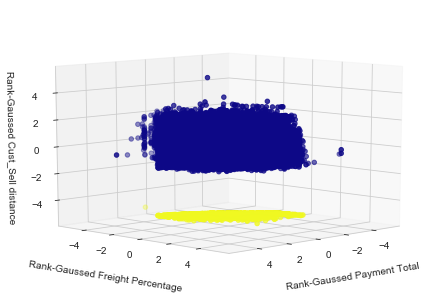

In [106]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data_selection['N_RG_payment_total'],
           data_selection['N_RG_freight_percentage'],
           data_selection['N_RG_cust_sell_dist'],
           cmap='plasma',
           c=kmeans_optimal.labels_)
ax.view_init(elev=10, azim=45)
ax.set_xlabel('Rank-Gaussed Payment Total', labelpad=15)
ax.set_ylabel('Rank-Gaussed Freight Percentage', labelpad=15)
ax.set_zlabel('Rank-Gaussed Cust_Sell distance')

Text(0.5, 0, 'Rank-Gaussed Delivery vs Estimated')

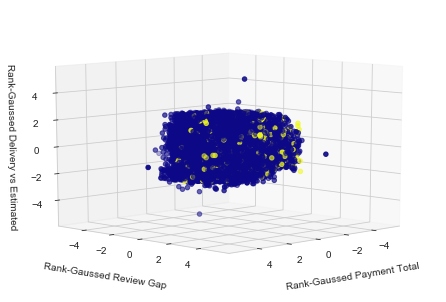

In [108]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data_selection['N_RG_payment_total'],
           data_selection['N_RG_review_gap'],
           data_selection['N_RG_delivery_vs_estimated'],
           cmap='plasma',
           c=kmeans_optimal.labels_)
ax.view_init(elev=10, azim=45)
ax.set_xlabel('Rank-Gaussed Payment Total', labelpad=15)
ax.set_ylabel('Rank-Gaussed Review Gap', labelpad=15)
ax.set_zlabel('Rank-Gaussed Delivery vs Estimated')

# DBSCAN

In [480]:
data_sample_20 = pd.DataFrame(data_selection).sample(
    int(data_selection.shape[0]/5),
    random_state=42)
data_sample_20.shape

(18072, 5)

In [481]:
data_sample_20.sample(3)

,N_RG_payment_total,N_RG_freight_percentage,N_RG_review_gap,N_RG_delivery_vs_estimated,N_RG_cust_sell_dist
28487,0.332656,-1.505758,-0.242903,-0.987837,-5.199338
11750,-1.861132,1.990412,-2.211226,-0.295415,0.139710
53824,0.349095,-0.465649,1.168949,-0.165327,-5.199338


In [498]:
# Compute DBSCAN
db = DBSCAN(eps=1.7, min_samples=8, metric='cityblock').fit(data_sample_20)
labels = db.labels_

In [499]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 77


In [500]:
print('Silhouette Coefficient: %0.3f'
      % metrics.silhouette_score(data_sample_20, labels))

Silhouette Coefficient: 0.379


In [501]:
data_sample_20['cluster_dbscan'] = labels

In [502]:
data_sample_20['cluster_dbscan'].unique()

array([ 0,  1,  2,  3, -1], dtype=int64)

Text(0.5, 1.02, 'Cluster nb')

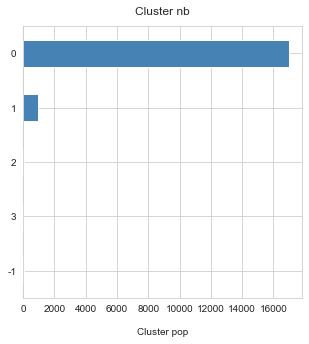

In [503]:
# observer la répartition des effectifs dans les clusters
data_sample_20['cluster_dbscan'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Cluster pop', labelpad=14)
plt.title('Cluster nb', y=1.02)

# K-Modes

In [129]:
# projection des données sur les features
mode_selection = for_lvl_features + ['charm_price']
data_mode_selection = data.filter(mode_selection)
data_mode_selection.shape

(90360, 6)

In [130]:
data_mode_selection.sample(3)

,payment_lvl,delivery_vs_estimated_lvl,freight_percentage_lvl,cust_sell_dist_lvl,review_gap_lvl,charm_price
60517,Light_Paiement,Late_Delivery,AroundMed_FreightCost,AroundMed_Dist,LowerMed_Review,1
78232,Light_Paiement,Soon_Delivery,AroundMed_FreightCost,Near_Dist,AroundMed_Review,1
47972,AroundMed_Paiement,OnTime_Delivery,AroundMed_FreightCost,Near_Dist,AroundMed_Review,0


In [131]:
km = KModes(n_clusters=5, init='Huang', n_init=5, verbose=1)

In [132]:
clusters = km.fit_predict(data_mode_selection)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 25111, cost: 176406.0
Run 1, iteration: 2/100, moves: 8691, cost: 176406.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 7117, cost: 189130.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 27487, cost: 179021.0
Run 3, iteration: 2/100, moves: 4934, cost: 179021.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1865, cost: 193443.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 11964, cost: 176324.0
Best run was number 5


In [133]:
# Print the cluster centroids
print(km.cluster_centroids_)

[['AroundMed_Paiement' 'OnTime_Delivery' 'BelowMed_FreightCost'
  'Near_Dist' 'AroundMed_Review' '1']
 ['Light_Paiement' 'OnTime_Delivery' 'OverMed_FreightCost'
  'AroundMed_Dist' 'AroundMed_Review' '1']
 ['AroundMed_Paiement' 'OnTime_Delivery' 'AroundMed_FreightCost'
  'AroundMed_Dist' 'AroundMed_Review' '1']
 ['Light_Paiement' 'Late_Delivery' 'AroundMed_FreightCost' 'Near_Dist'
  'UpperMed_Review' '0']
 ['AroundMed_Paiement' 'Late_Delivery' 'OverMed_FreightCost'
  'AroundMed_Dist' 'LowerMed_Review' '1']]


In [136]:
km10 = KModes(n_clusters=5, init='Huang', n_init=10, verbose=1)

In [137]:
clusters10 = km10.fit_predict(data_mode_selection)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 180549.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 30211, cost: 180127.0
Run 2, iteration: 2/100, moves: 5553, cost: 180127.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 3657, cost: 177279.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 8526, cost: 183349.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 181246.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 15126, cost: 175534.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 27437, cost: 180041.0
Init: initializing 

In [139]:
# Print the cluster centroids
print(km10.cluster_centroids_)

[['AroundMed_Paiement' 'Late_Delivery' 'BelowMed_FreightCost' 'Near_Dist'
  'AroundMed_Review' '1']
 ['Light_Paiement' 'OnTime_Delivery' 'OverMed_FreightCost' 'Far_Dist'
  'AroundMed_Review' '1']
 ['Light_Paiement' 'OnTime_Delivery' 'OverMed_FreightCost'
  'AroundMed_Dist' 'AroundMed_Review' '0']
 ['AroundMed_Paiement' 'OnTime_Delivery' 'AroundMed_FreightCost'
  'AroundMed_Dist' 'AroundMed_Review' '1']
 ['AroundMed_Paiement' 'Soon_Delivery' 'AroundMed_FreightCost'
  'Near_Dist' 'UpperMed_Review' '1']]


In [575]:
km10.labels_

array([0, 0, 3, ..., 0, 1, 1], dtype=uint16)

In [576]:
KModeClust = data.copy()

In [577]:
KModeClust['clusters'] = km10.labels_

Text(0.5, 1.02, 'Cluster nb')

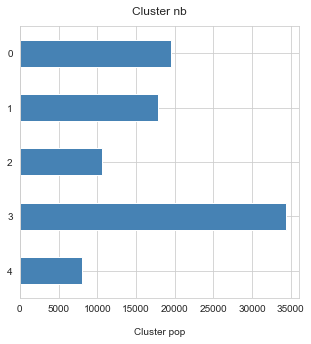

In [578]:
# observer la répartition des effectifs dans les clusters
KModeClust['clusters'].value_counts(sort=False).plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Cluster pop', labelpad=14)
plt.title('Cluster nb', y=1.02)

Text(0.5, 0, 'Rank-Gaussed Cust_Sell distance')

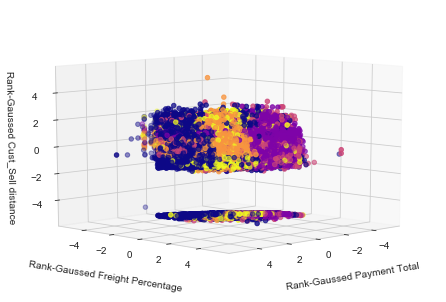

In [580]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(KModeClust['N_RG_payment_total'],
           KModeClust['N_RG_freight_percentage'],
           KModeClust['N_RG_cust_sell_dist'],
           cmap='plasma',
           c=KModeClust['clusters'])
ax.view_init(elev=10, azim=45)
ax.set_xlabel('Rank-Gaussed Payment Total', labelpad=15)
ax.set_ylabel('Rank-Gaussed Freight Percentage', labelpad=15)
ax.set_zlabel('Rank-Gaussed Cust_Sell distance')

Text(0.5, 0, 'Rank-Gaussed Cust_Sell distance')

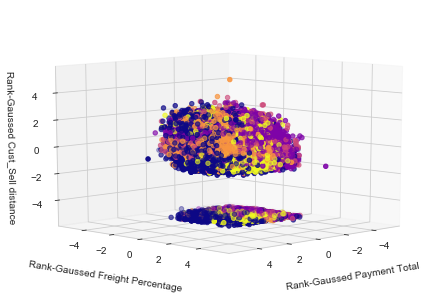

In [581]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(KModeClust['N_RG_payment_total'],
           KModeClust['N_RG_review_gap'],
           data_selection['N_RG_cust_sell_dist'],
           cmap='plasma',
           c=KModeClust['clusters'])
ax.view_init(elev=10, azim=45)
ax.set_xlabel('Rank-Gaussed Payment Total', labelpad=15)
ax.set_ylabel('Rank-Gaussed Freight Percentage', labelpad=15)
ax.set_zlabel('Rank-Gaussed Cust_Sell distance')

Text(0.5, 1.02, 'Purchase Time Zones')

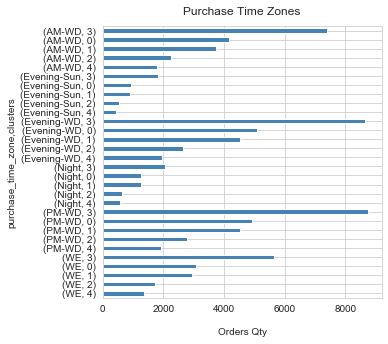

In [584]:
KModeClust.groupby('purchase_time_zone').clusters.value_counts().plot(
        kind='barh',
        color='steelblue',
        figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Purchase Time Zones', y=1.02)